In [119]:
!pip install torchvision

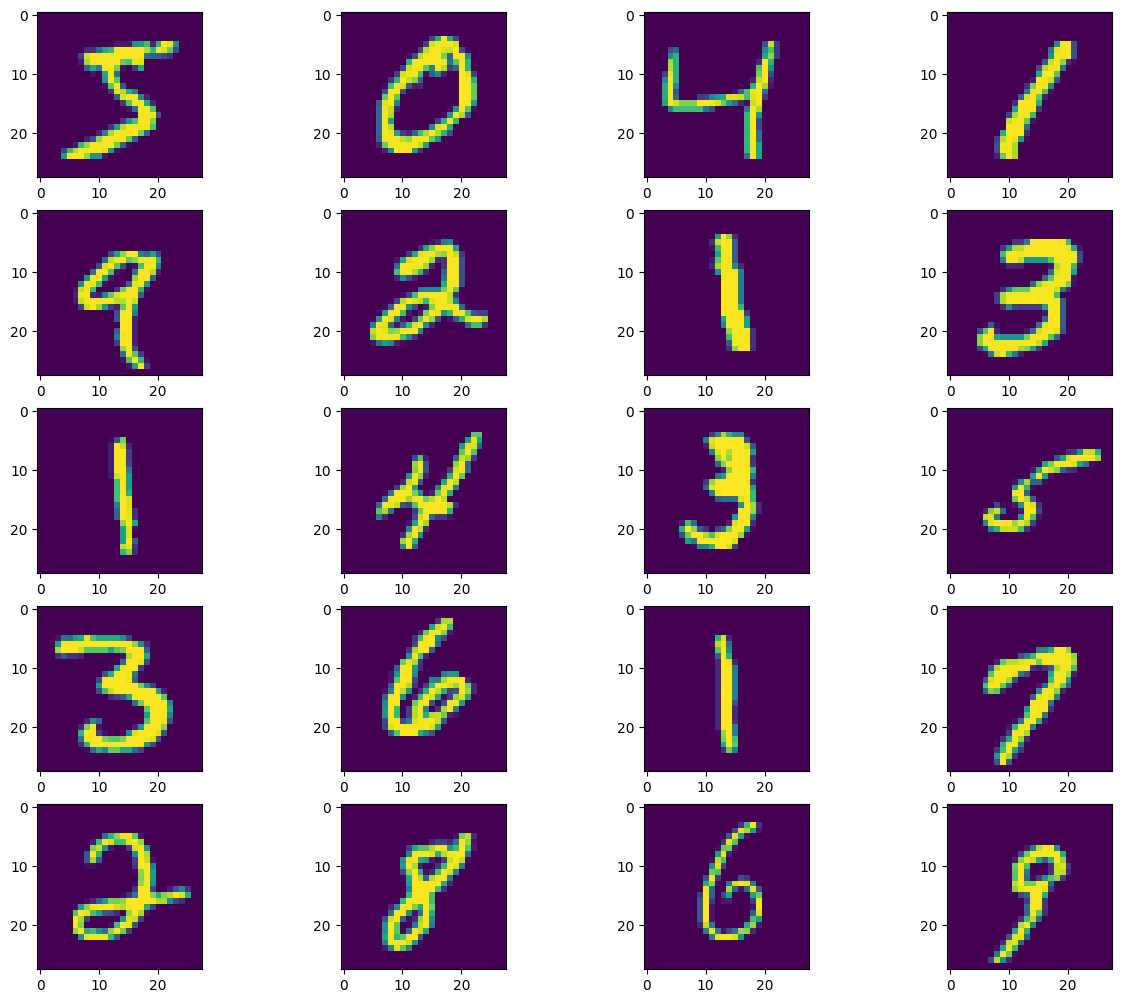

In [120]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.MNIST("", download=True)
show_images(data)

In [121]:
from torch.utils.data import Subset
subset = Subset(data,range(0,100))

In [122]:
data = subset

In [123]:

import sys
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error as mse

from typing import List, Tuple, OrderedDict
from collections import OrderedDict
import warnings
import io

In [124]:
!pip install scikit-learn

In [125]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim: int, output_shape: Tuple[int, int, int]):
        super().__init__()
        self.linear = nn.Linear(latent_dim, 4 * 4 * 128)
        self.trans1 = nn.ConvTranspose2d(128, 128, 4, 2, 1)
        self.trans2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.trans3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.conv4 = nn.Conv2d(32, output_shape[0], 3, 1, 1)
        self.relu = nn.ReLU()

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = self.linear(z)
        z = z.view(-1, 128, 8, 8)
        z = self.relu(self.trans1(z))
        z = self.relu(self.trans2(z))
        z = self.relu(self.trans3(z))
        output = torch.sigmoid(self.conv4(z))
        return output


class ConvEncoder(nn.Module):
    def __init__(self, input_shape: Tuple[int, int, int], latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.conv1 = nn.Conv2d(input_shape[0], 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 2, 1)
        self.fc = nn.Linear(4 * 4 * 256, 2 * self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        mu, log_std = x.chunk(2, dim=1)
        return mu, log_std


class ConvVAE(nn.Module):
    def __init__(self, input_shape: Tuple[int, int, int], latent_size: int):
        super().__init__()
        assert len(input_shape) == 3
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.latent_size = latent_size
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = ConvDecoder(latent_size, input_shape)
        self.register_buffer("mu_prior", torch.tensor(0.))
        self.register_buffer("std_prior", torch.tensor(1.))
    def prior(self):
        return torch.distributions.Normal(self.mu_prior, self.std_prior)

    def reconstruction_loss(self, x: torch.Tensor, x_recon: torch.Tensor) -> torch.Tensor:
        recon_loss = F.mse_loss(x_recon, x, reduction='sum')
        return recon_loss

    def kl_loss(self, mu: torch.Tensor, log_std: torch.Tensor) -> torch.Tensor:
        kl_loss = -0.5 * torch.sum(16 + 2 * log_std - mu.pow(2) - (2 * log_std).exp(), dim=1).mean()
        return kl_loss

    def loss(self, x: torch.Tensor) -> OrderedDict[str, torch.Tensor]:
        mu, log_std = self.encoder(x)
        eps = self.prior().sample(mu.shape)
        z = mu + log_std.exp() * eps
        x_recon = self.decoder(z)
        recon_loss = self.reconstruction_loss(x, x_recon)
        kl_loss = self.kl_loss(mu, log_std)
        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)
    def sample(self, n: int) -> np.ndarray:

        with torch.no_grad():
            z = torch.randn(n, self.latent_size, device = self.device)
            samples = self.decoder(z)
        return samples

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, log_std = self.encoder(x)
        z = mu + log_std.exp() * torch.randn_like(log_std)
        x_recon = self.decoder(z)
        return x_recon, mu, log_std, z

In [126]:
def plot_vae_training_plot(train_losses: np.ndarray, title: str):
    train_losses = train_losses[2:]
    vlb_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    plt.figure()
    n_epochs = len(train_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, vlb_train, label='-vlb_train')
    plt.plot(x_train, recon_train, label='recon_loss_train')
    plt.plot(x_train, kl_train, label='kl_loss_train')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def scatter_2d(data: np.ndarray, title: str):
    plt.figure()
    plt.title(title)
    plt.scatter(data[:, 0], data[:, 1])

In [127]:
def train_one_epoch(model: nn.Module, train_loader: DataLoader, optimizer: optim) -> OrderedDict[str, List[torch.Tensor]]:
    model.train()
    losses = OrderedDict([('loss', []), ('recon_loss', []), ('kl_loss', [])])
    for x in train_loader:
        x = x[0] if isinstance(x, list) else x
        x = x.to(device)
        optimizer.zero_grad()
        loss_dict = model.loss(x)
        loss_dict['loss'].backward()
        optimizer.step()

        for name, loss in loss_dict.items():
            losses[name].append(loss.item())
    return losses


def eval(model: nn.Module, data_loader: DataLoader) -> OrderedDict[str, torch.Tensor]:
    model.eval()
    total_losses = OrderedDict([('loss', 0), ('recon_loss', 0), ('kl_loss', 0)])
    count = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            loss_dict = model.loss(x)
            count += x.size(0)

            for name, loss in loss_dict.items():
                total_losses[name] += loss.item() * x.size(0)

    for name in total_losses.keys():
        total_losses[name] /= count
    return total_losses


def train(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, epochs: int, lr: float) -> Tuple[np.ndarray, np.ndarray]:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = OrderedDict(), OrderedDict()
    for epoch in range(epochs):
        print(f"EPOCH {epoch} started")

        model.train()
        train_loss = train_one_epoch(model, train_loader, optimizer)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])
    return train_losses

In [129]:
device = 'mps'

In [130]:
def cosine_beta_schedule(timesteps, s=0.008):
    t = torch.arange(timesteps, dtype=torch.float32)
    T = timesteps - 1
    f_t = torch.cos((t / T + s) * torch.pi / (2*(1 + s)))**2
    f_0 = torch.cos(torch.tensor(s * torch.pi / (2*(1 + s))))**2
    alpha_tilde = f_t / f_0

    alpha_tilde_t = alpha_tilde[1:]
    alpha_tilde_t_minus_1 = alpha_tilde[:-1]

    beta_t = 1 - (alpha_tilde_t / alpha_tilde_t_minus_1)
    
    beta_t = torch.cat([torch.tensor([0.001]), torch.clip(beta_t, 0., 0.999)])

    return beta_t

In [131]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


T = 1000
betas = cosine_beta_schedule(timesteps=T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [137]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.MNIST(root="", download=True,
                                         transform=data_transform)

    test = torchvision.datasets.MNIST(root="", download=True,
                                         transform=data_transform, train=True)
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),#
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
data = Subset(data,range(0,15000))
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [138]:
data1 = torchvision.datasets.MNIST(root="", download=True)

In [156]:
next(iter(dataloader))[:-1]

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

In [146]:
dataloader

In [ ]:
model = model.to('cpu')

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.fc_mu = nn.Linear(256*4*4, 100)
        self.fc_logvar = nn.Linear(256*4*4, 100)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(100, 4096)
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 256, 4, 4)
        reconstruction = self.conv_layers(z)
        return torch.sigmoid(reconstruction)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

device = torch.device("mps" if torch.cuda.is_available() else "cpu")
vae.to(device)

for epoch in range(20):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')


Train Epoch: 0 [0/15000 (0%)]	Loss: 8413.583008
Train Epoch: 0 [256/15000 (2%)]	Loss: 8002.333008
Train Epoch: 0 [512/15000 (3%)]	Loss: 7413.506348
Train Epoch: 0 [768/15000 (5%)]	Loss: 7038.590332
Train Epoch: 0 [1024/15000 (7%)]	Loss: 6797.270996
Train Epoch: 0 [1280/15000 (9%)]	Loss: 6522.886719
Train Epoch: 0 [1536/15000 (10%)]	Loss: 6307.514160
Train Epoch: 0 [1792/15000 (12%)]	Loss: 6164.947754
Train Epoch: 0 [2048/15000 (14%)]	Loss: 6053.763672
Train Epoch: 0 [2304/15000 (15%)]	Loss: 5906.604980
Train Epoch: 0 [2560/15000 (17%)]	Loss: 5815.302246
Train Epoch: 0 [2816/15000 (19%)]	Loss: 5797.605469
Train Epoch: 0 [3072/15000 (21%)]	Loss: 5664.136719
Train Epoch: 0 [3328/15000 (22%)]	Loss: 5591.034180
Train Epoch: 0 [3584/15000 (24%)]	Loss: 5486.014648
Train Epoch: 0 [3840/15000 (26%)]	Loss: 5407.442383
Train Epoch: 0 [4096/15000 (27%)]	Loss: 5355.472656
Train Epoch: 0 [4352/15000 (29%)]	Loss: 5260.287598
Train Epoch: 0 [4608/15000 (31%)]	Loss: 5191.801270
Train Epoch: 0 [4864/150

In [166]:
def sample_vae(model, device, num_samples=1):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 100).to(device)
        samples = model.decoder(z)
    return samples

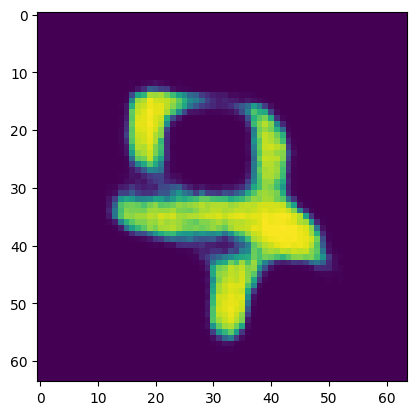

In [203]:
samples = sample_vae(vae, 'cpu')
show_tensor_image(samples)

In [191]:
image = next(iter(dataloader))[0]

In [194]:
def encode_decode(model, image, device):
    model.eval()
    image = image.to(device)

    with torch.no_grad():
        mu, logvar = model.encoder(image)
        z = model.reparameterize(mu, logvar)
        reconstructed_image = model.decoder(z)

    return reconstructed_image

reconstructed_image = encode_decode(vae, image, 'cpu')


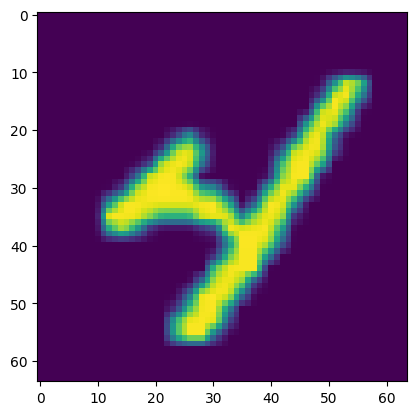

In [192]:
show_tensor_image(image)

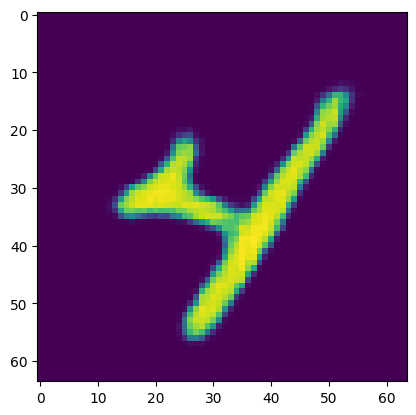

In [195]:
show_tensor_image(reconstructed_image)

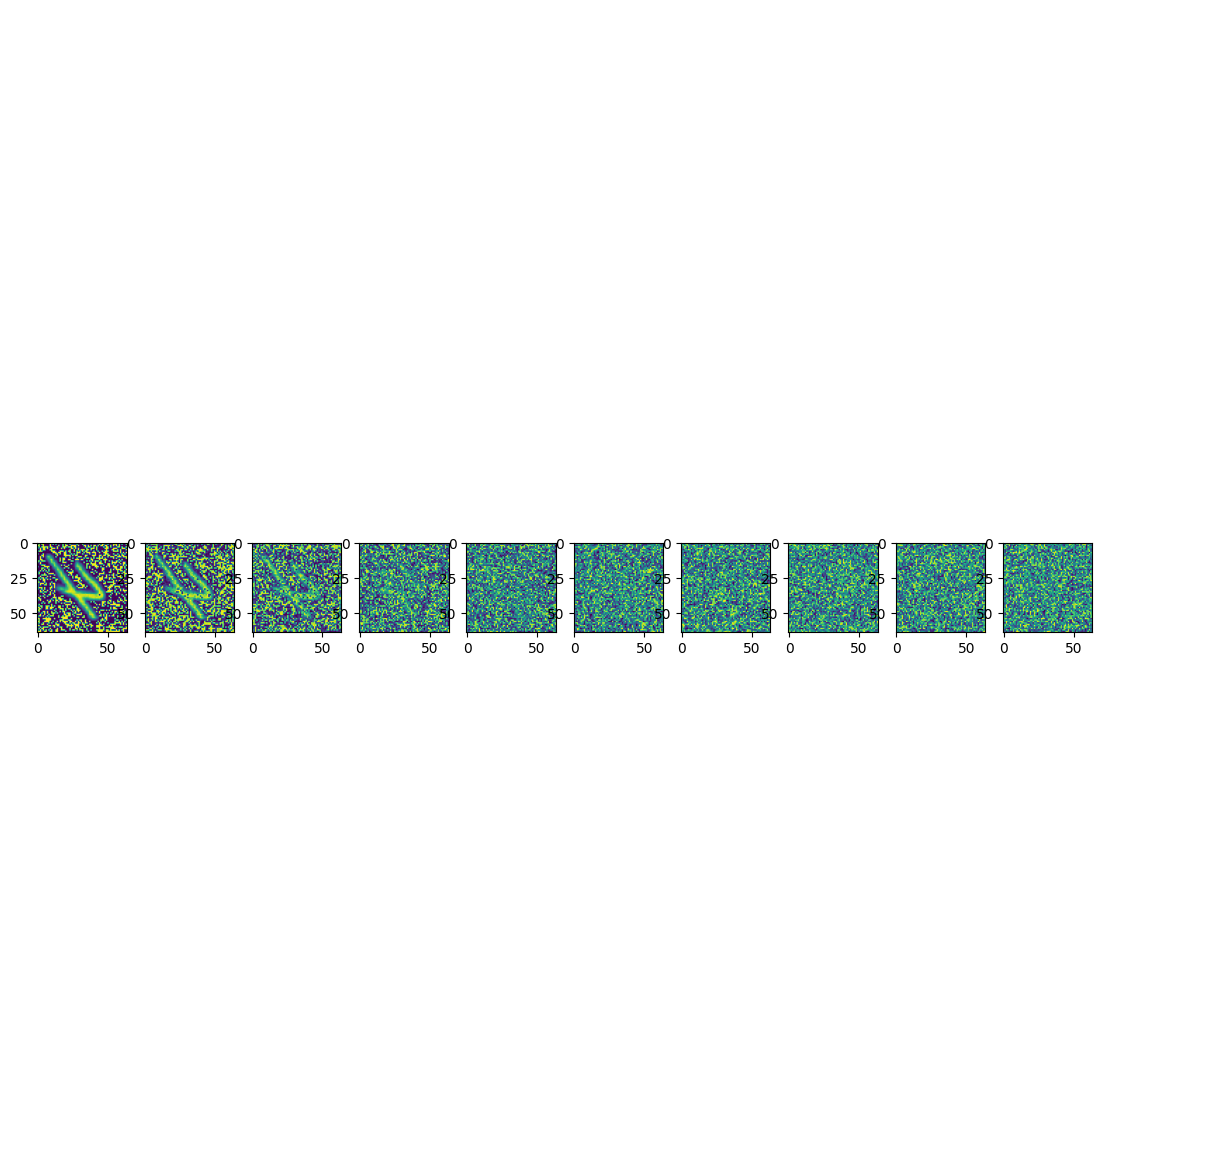

In [187]:
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [ ]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    img_size = IMG_SIZE
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 5
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0 or i == 1:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Training

In [ ]:
from torch.optim import Adam

device = "mps"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 200

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

In [ ]:
for _ in range(10):
    sample_plot_image()

In [ ]:
for _ in range(10):
    sample_plot_image()

In [ ]:
torch.save(model.state_dict(), 'model_state_cosine_scheduler_15k_200_epochs')